# Beyond the Code: Who Developers Are and What Drives Them

## By Abhi Jindal, Shi Qui (Ariel),Arshdeep Singh Oberoi, Mokhinur Talibzhanova



## Business Problem Definition + Description
This project aims to predict liquor sales in Iowa using historical sales data to understand purchasing trends and help optimize store-level inventory. Specifically, we seek to forecast the monthly sales (in dollars) for liquor stores based on product category, store attributes, and seasonal patterns. The model will help identify which factors—such as product type, region, or time of year—most strongly influence sales volumes. Predicting these trends has direct implications for supply chain management, pricing, and retail decision-making.


## Executive Summary
Our project predicts monthly liquor sales for Iowa retailers to optimize inventory and supply chain management. Using historical transaction data from the Iowa Department of Commerce , we aggregated over 25 million records into store-level monthly forecasts.

Our methodology progressed from baseline linear models (Lasso, Ridge) to advanced ensemble methods (Random Forest, XGBoost). We employed Bayesian Hyperparameter Optimization to fine-tune our best model and used Bootstrapping with paired t-tests to validate statistical significance. The results demonstrate that the Bayesian Tuned XGBoost model offers the highest predictive accuracy, successfully capturing non-linear factors such as seasonality and geographic clustering. These insights allow retailers and policymakers to anticipate demand fluctuations and mitigate both stockouts and excess inventory.

## Dataset
The dataset used is the Iowa Liquor Sales (https://data.iowa.gov/) dataset hosted on Kaggle (https://www.kaggle.com/datasets/residentmario/iowa-liquor-sales), originally compiled by the Iowa Alcoholic Beverages Division (ABD) and later uploaded to Kaggle by the user residentmario.


In [ ]:
%pip install pandas
%pip install numpy
%pip install scipy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install squarify
%pip install plotly
%pip install wordcloud
%pip install ipywidgets
%pip install nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-Learn Preprocessing & Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector

# Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.utils import resample
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00


## Data Loading and Cleaning Process

In [ ]:
# LOAD DATA
sheet_id = "10H2zBzH2lEVb9rJmnIg05oSluNUp-9c4"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"
iowa_sales = pd.read_csv(url)

## Cleaning Description

To prepare the raw transaction data for machine learning, we performed the following rigorous cleaning steps:


* Coordinate Extraction: Raw geospatial points (e.g., "POINT (-91.5 41.6)") were parsed into separate Latitude and Longitude columns to enable spatial clustering.

* Handling Returns: The dataset contained negative values representing product returns. These were filtered out to prevent skewing the sales predictions.


* Temporal Aggregation: As the business goal is monthly forecasting, daily transactions were grouped by Store, Year, and Month.

###Feature Engineering:

* Lag Features: We created lag_sales (previous month’s sales) to use as the primary predictor for the target target_next_month_sales.

* Geographic Clustering (RBF): We implemented a custom Transformer using K-Means clustering on Latitude/Longitude. This grouped stores into "regions" and calculated similarity scores, allowing the model to learn spatial dependencies.

* Log Transformation: Analyzing the distribution revealed high skewness in sales data. We applied a safe_log transform (np.log1p) to normalize the target and lag features, improving model stability.

* Imputation: A SimpleImputer was integrated into the pipeline to handle missing values in price or location data automatically using median strategies.

In [ ]:
# Clean Column Names
iowa_sales.columns = iowa_sales.columns.str.strip().str.lower().str.replace(' ', '_')

# Handle Dates
iowa_sales['date'] = pd.to_datetime(iowa_sales['date'])
iowa_sales['year'] = iowa_sales['date'].dt.year
iowa_sales['month'] = iowa_sales['date'].dt.month

# Handle Coordinates
if 'latitude' in iowa_sales.columns and 'longitude' in iowa_sales.columns:
    iowa_sales['latitude'] = pd.to_numeric(iowa_sales['latitude'], errors='coerce')
    iowa_sales['longitude'] = pd.to_numeric(iowa_sales['longitude'], errors='coerce')
elif 'store_location' in iowa_sales.columns:
    print("Extracting coordinates from 'store_location'...")
    iowa_sales['longitude'] = iowa_sales['store_location'].str.extract(r'POINT \((.*?) ').astype(float)
    iowa_sales['latitude'] = iowa_sales['store_location'].str.extract(r' (.*?)\)').astype(float)
else:
    # Dummy values if missing to prevent crash
    iowa_sales['latitude'] = 0.0
    iowa_sales['longitude'] = 0.0

# Drop Missing Critical Values
cols_to_check = ['sale_dollars', 'bottles_sold', 'date']
iowa_sales = iowa_sales.dropna(subset=cols_to_check)

# Aggregate to Monthly Data
print("Aggregating to Store-Month Level...")
monthly_data = iowa_sales.groupby(['store_name', 'year', 'month']).agg({
    'sale_dollars': 'sum',
    'bottles_sold': 'sum',
    'state_bottle_retail': 'mean',
    'latitude': 'first',
    'longitude': 'first',
    'county': 'first'
}).reset_index()

# Create Target & Lags
monthly_data.sort_values(['store_name', 'year', 'month'], inplace=True)
monthly_data['target_next_month_sales'] = monthly_data.groupby('store_name')['sale_dollars'].shift(-1)
monthly_data['lag_sales'] = monthly_data['sale_dollars']
monthly_data['lag_bottles'] = monthly_data['bottles_sold']

# Drop rows where target is missing (last month for each store)
model_df = monthly_data.dropna(subset=['target_next_month_sales']).copy()

# Remove Negative Sales (Returns)
model_df = model_df[
    (model_df['lag_sales'] >= 0) &
    (model_df['lag_bottles'] >= 0) &
    (model_df['target_next_month_sales'] >= 0)
].copy()

print(f"Final Dataset Shape: {model_df.shape}")

Extracting coordinates from 'store_location'...
Aggregating to Store-Month Level...
Final Dataset Shape: (17722, 12)


In [ ]:
monthly_sales = (iowa_sales.groupby([iowa_sales['date'].dt.to_period('M')])['sale_dollars']
    .sum()
    .reset_index())
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Total sales by store
store_sales = (
    iowa_sales.groupby('store_name')['sale_dollars']
    .sum()
    .sort_values(ascending=False)
    .reset_index())

# Total sales by liquor category
category_sales = (
    iowa_sales.groupby('category_name')['sale_dollars']
    .sum()
    .sort_values(ascending=False)
    .reset_index())

# Total sales by county (optional, for geographic insights)
county_sales = (
    iowa_sales.groupby('county')['sale_dollars']
    .sum()
    .sort_values(ascending=False)
    .reset_index())

print(f"Monthly sales: {monthly_sales.shape}, Store sales: {store_sales.shape}, Category sales: {category_sales.shape}")

Monthly sales: (120, 2), Store sales: (2293, 2), Category sales: (86, 2)


Summary Statistics:


,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000,24991.000000
mean,395.276219,13.304411,19.959104,2.398583,35.885969,0.515873,0.131796
std,321.629199,21.054541,31.581480,3.066703,55.207662,0.720118,0.190138
min,20.000000,0.890000,1.340000,-96.000000,-2519.160000,-84.000000,-22.190000
25%,50.000000,5.000000,7.500000,1.000000,11.250000,0.200000,0.050000
50%,375.000000,7.870000,11.810000,1.000000,19.500000,0.600000,0.150000
75%,750.000000,13.500000,20.250000,2.000000,38.790000,0.750000,0.190000
max,1750.000000,2000.000000,3000.000000,20.000000,3000.000000,1.120000,0.290000


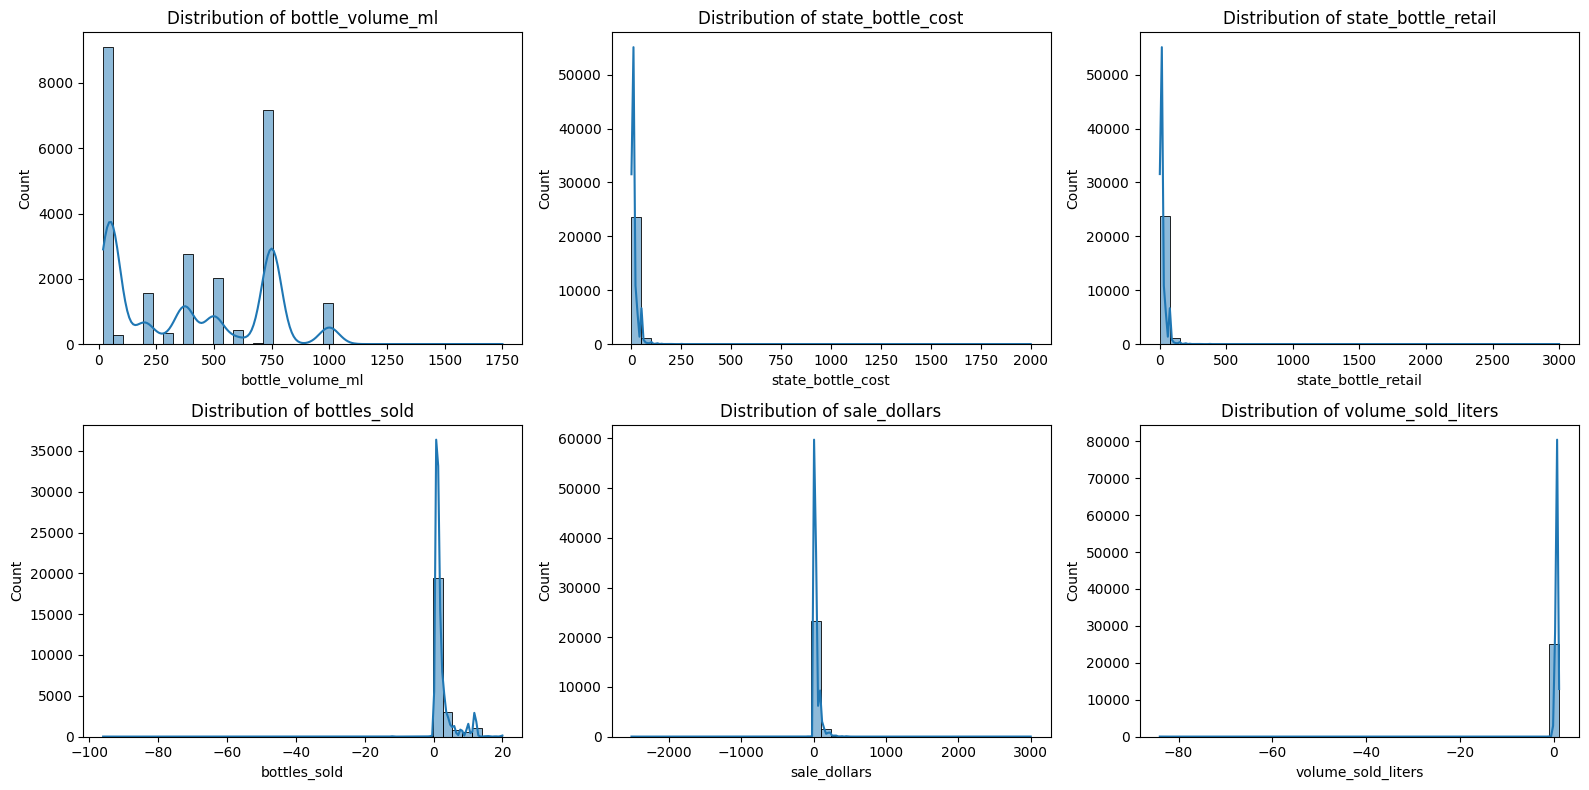

In [ ]:
# Summary Statistics
numeric_cols = ['bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
                'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons']

print("Summary Statistics:")
display(iowa_sales[numeric_cols].describe())

# Visualize Distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):
    sns.histplot(iowa_sales[col], bins=40, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

### Interpretation
These histograms reveal that variables like sale_dollars and bottles_sold are highly right-skewed (long tails). This indicates that while most transactions are small, a few massive orders drive the bulk of the volume, necessitating the Log Transformation used later in the pipeline.

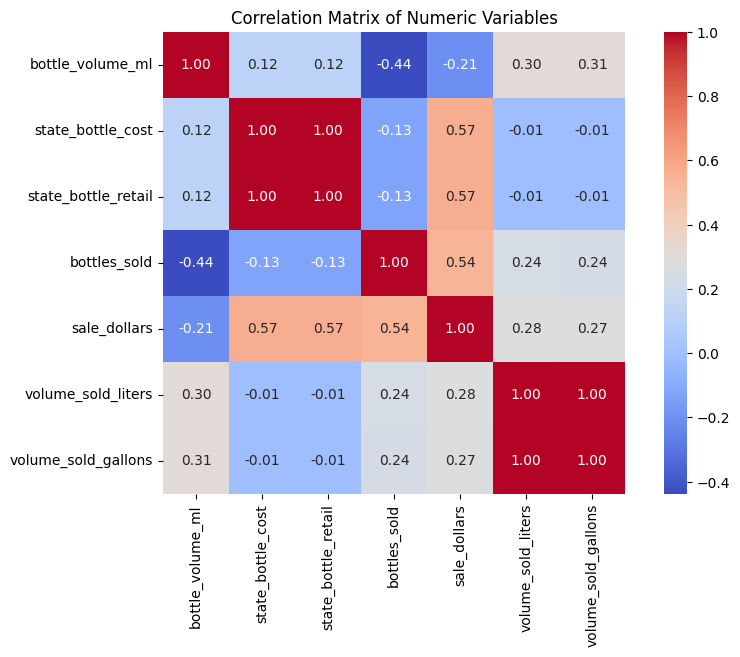

In [ ]:
# Correlation Matrix
corr = iowa_sales[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

### Interpretation
Strong red squares (correlation ~1.0) exist between state_bottle_retail and state_bottle_cost, which is expected (markup is fixed). More importantly, bottles_sold has a high correlation with sale_dollars, confirming that volume, not just price, is the primary driver of revenue.

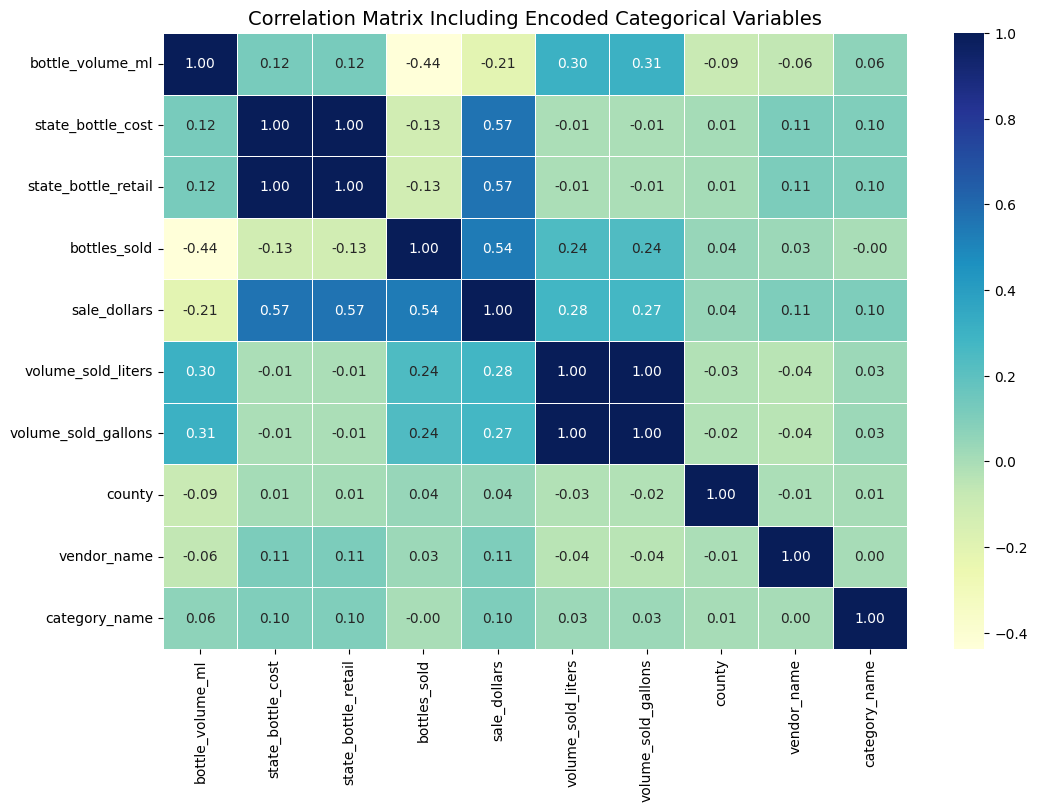

In [ ]:
# Select categorical variables of interest
cat_vars = ['county', 'vendor_name', 'category_name']

# Make a copy to preserve original data
corr_df = iowa_sales.copy()

# Encode categorical variables numerically
le = LabelEncoder()
for col in cat_vars:
    corr_df[col] = le.fit_transform(corr_df[col].astype(str))

# Select numeric + encoded categorical columns for correlation
corr_cols = ['bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
             'bottles_sold', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'] + cat_vars

corr_matrix = corr_df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Matrix Including Encoded Categorical Variables", fontsize=14)
plt.show()

### Interpretation
This heatmap shows how location (county) and product type (category_name) interact with sales. Low correlation values here suggest that no single category or county dictates sales alone, reinforcing the need for non-linear models like XGBoost to capture complex interactions.

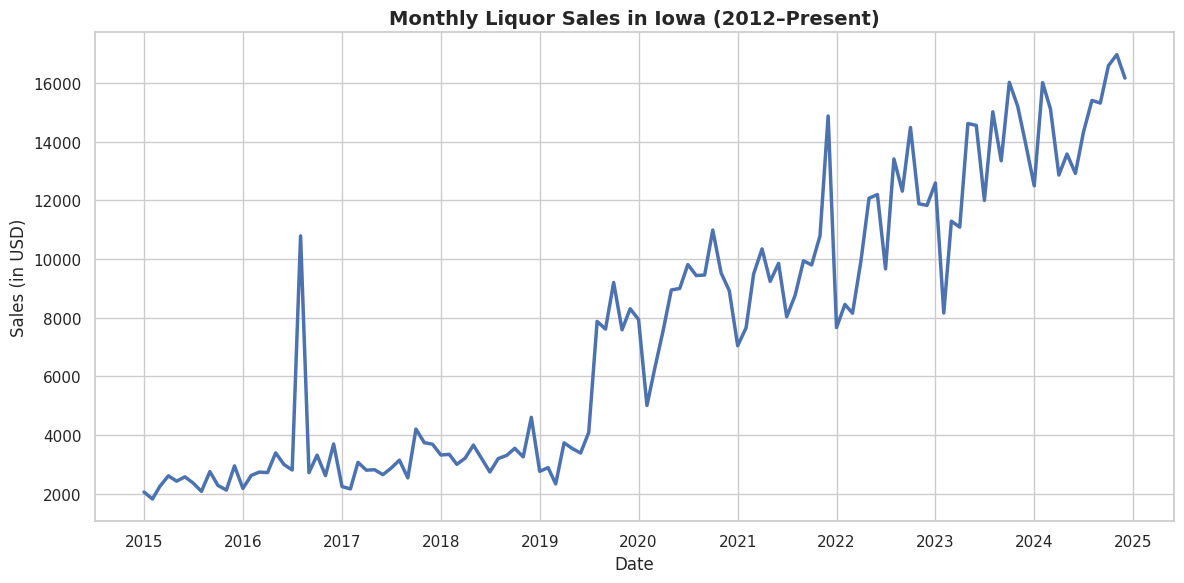

In [ ]:
sns.set_theme(style="whitegrid", palette="deep")

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='date', y='sale_dollars', linewidth=2.5)
plt.title('Monthly Liquor Sales in Iowa (2012–Present)', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Sales (in USD)')
plt.tight_layout()
plt.show()


### Interpretation
The timeline shows a clear, repetitive "heartbeat" pattern with sharp peaks in December of every year. This confirms strong seasonality (holiday demand) and justifies using Month as a key predictor variable.

/tmp/ipython-input-146900421.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_stores, y='store_name', x='sale_dollars', palette='Blues_r')


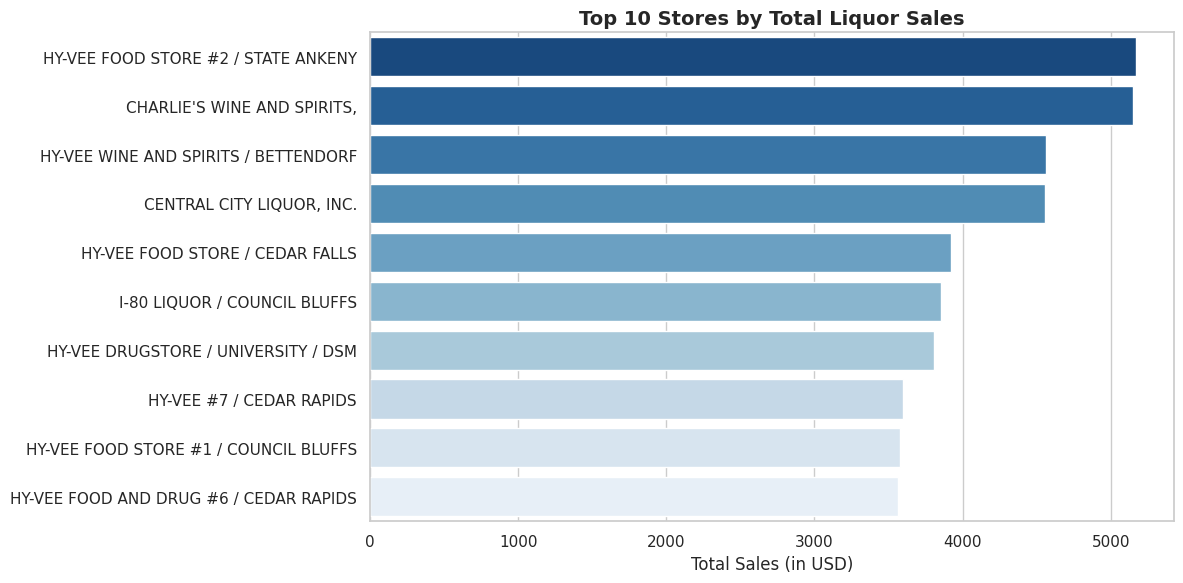

In [ ]:
top10_stores = store_sales.head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top10_stores, y='store_name', x='sale_dollars', palette='Blues_r')
plt.title('Top 10 Stores by Total Liquor Sales', fontsize=14, weight='bold')
plt.xlabel('Total Sales (in USD)')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Interpretation
These charts illustrate a "Pareto Principle" (80/20 rule). A small number of categories (Whiskies, Vodkas) and specific high-volume stores (likely supermarkets like Hy-Vee) generate a disproportionate amount of revenue, suggesting inventory priority should be focused on these top performers.

/tmp/ipython-input-2872543182.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_categories, y='category_name', x='sale_dollars', palette='Oranges_r')


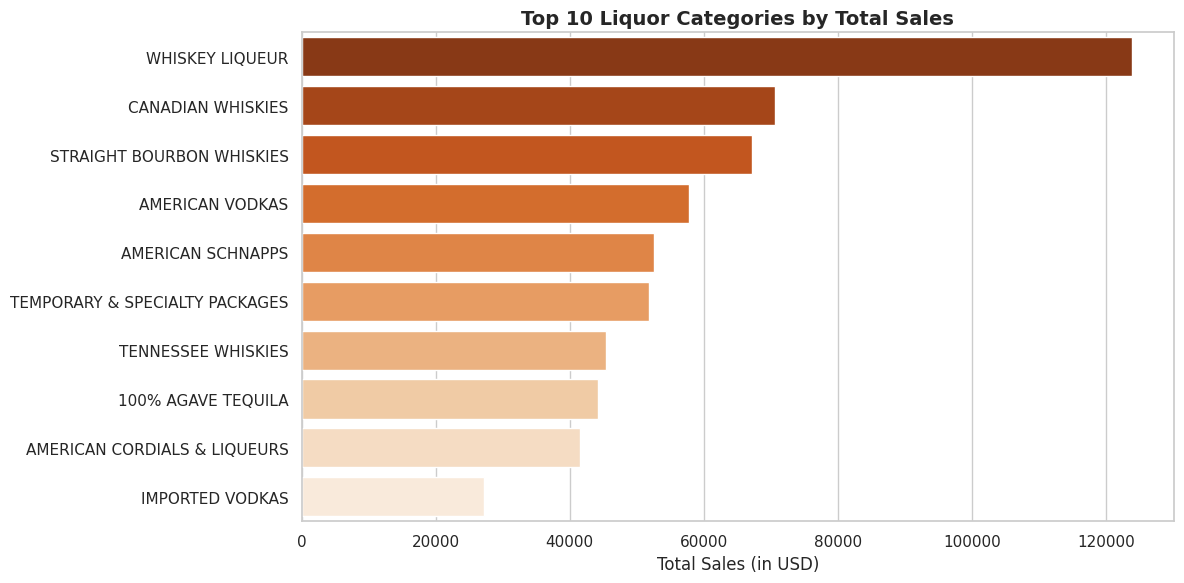

In [ ]:
top10_categories = category_sales.head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top10_categories, y='category_name', x='sale_dollars', palette='Oranges_r')
plt.title('Top 10 Liquor Categories by Total Sales', fontsize=14, weight='bold')
plt.xlabel('Total Sales (in USD)')
plt.ylabel('')
plt.tight_layout()
plt.show()

Data Split Created (X_train, y_train defined).


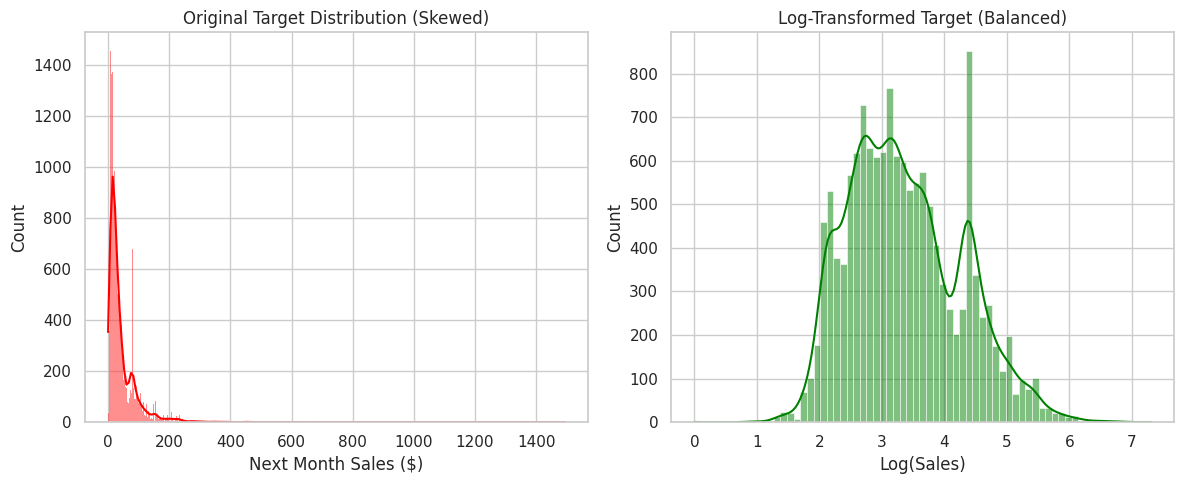

In [ ]:
# Minimal features needed just to define the split
X = model_df[['lag_sales', 'lag_bottles', 'month']]
y = model_df['target_next_month_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Split Created (X_train, y_train defined).")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color='red')
plt.title("Original Target Distribution (Skewed)")
plt.xlabel("Next Month Sales ($)")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(y_train), kde=True, color='green')
plt.title("Log-Transformed Target (Balanced)")
plt.xlabel("Log(Sales)")

plt.tight_layout()
plt.show()

In [ ]:
# FEATURE ENGINEERING

# Train-Test Split
X = model_df[['lag_sales', 'lag_bottles', 'latitude', 'longitude', 'state_bottle_retail', 'month']]
y = model_df['target_next_month_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data Split: {len(X_train)} train rows, {len(X_test)} test rows.")

# Define Custom Geographic Transformer
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        if len(X) < self.n_clusters:
            self.n_clusters = max(1, len(X))
        self.kmeans_ = KMeans(self.n_clusters, n_init='auto', random_state=self.random_state)
        self.kmeans_.fit(X)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"geo_cluster_{i}" for i in range(self.n_clusters)]

# Define Safe Log Transformer
def safe_log(x):
    return np.log1p(np.maximum(x, 0))

log_transformer = FunctionTransformer(safe_log, validate=False, feature_names_out="one-to-one")

# Build Preprocessing Pipeline
geo_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42))

preprocessor = ColumnTransformer([
    ('log_lags', make_pipeline(SimpleImputer(strategy='median'), log_transformer, StandardScaler()), ['lag_sales', 'lag_bottles']),
    ('geo', geo_pipeline, ['latitude', 'longitude']),
    ('price', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), ['state_bottle_retail']),
    ('time', make_pipeline(SimpleImputer(strategy='most_frequent')), ['month'])])

print("Preprocessing Pipeline Created.")

Data Split: 14177 train rows, 3545 test rows.
Preprocessing Pipeline Created.


In [ ]:
#  MODEL TRAINING

# 1. Clean Data for Linear Models (Target Only)
train_data = X_train.copy()
train_data['target'] = y_train

train_data = train_data[np.isfinite(train_data['target'])]

X_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

print(f"Training Lasso/Ridge on {len(X_train_clean)} rows.")

if len(X_train_clean) == 0:
    print("ERROR: Training data is still empty. Check Block 1 'target_next_month_sales' creation.")
else:
    # 1. Lasso Regression (L1)
    print("\n--- Tuning Lasso ---")
    lasso_config = {
        "model": Lasso(random_state=42, max_iter=5000),
        "params": {"model__alpha": [0.01, 0.1, 1.0, 10.0]}}

    lasso_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', lasso_config['model'])])

    lasso_search = RandomizedSearchCV(
        lasso_pipeline, lasso_config['params'], n_iter=4,
        scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

    try:
        lasso_search.fit(X_train_clean, y_train_clean)
        best_lasso = lasso_search.best_estimator_
        print(f"Best Lasso RMSE: {-lasso_search.best_score_:.2f}")
    except Exception as e:
        print(f"Lasso Skipped due to error: {e}")
        best_lasso = None

    # 2. Ridge Regression (L2)
    print("\nTuning Ridge")
    ridge_config = {
        "model": Ridge(random_state=42),
        "params": {"model__alpha": [0.1, 1.0, 10.0, 100.0]}}

    ridge_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', ridge_config['model'])])

    ridge_search = RandomizedSearchCV(
        ridge_pipeline, ridge_config['params'], n_iter=4,
        scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

    try:
        ridge_search.fit(X_train_clean, y_train_clean)
        best_ridge = ridge_search.best_estimator_
        print(f"Best Ridge RMSE: {-ridge_search.best_score_:.2f}")
    except Exception as e:
        print(f"Ridge Skipped due to error: {e}")
        best_ridge = None

    # 3. XGBoost (Standard)
    print("\nTuning XGBoost")
    xgb_config = {
        "model": XGBRegressor(random_state=42, objective='reg:squarederror'),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, 5]}}

    xgb_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', xgb_config['model'])])

    xgb_search = RandomizedSearchCV(
        xgb_pipeline, xgb_config['params'], n_iter=4,
        scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_
    print(f"Best XGBoost RMSE: {-xgb_search.best_score_:.2f}")

    # 4. SVR (Support Vector Regression)
    print("\nTuning SVR (on subset)")
    svr_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', SVR(kernel='rbf', C=100, epsilon=0.1))])

    # Downsample for SVR speed
    if len(X_train) > 2000:
        X_svr, y_svr = resample(X_train, y_train, n_samples=2000, random_state=42)
    else:
        X_svr, y_svr = X_train, y_train

    svr_pipeline.fit(X_svr, y_svr)
    best_svr = svr_pipeline
    print("SVR Trained.")

    # 5. Random Forest & Bagging
    print("\n Training Ensembles")
    # Random Forest
    rf_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))])
    rf_pipeline.fit(X_train, y_train)
    best_rf = rf_pipeline
    print("Random Forest Trained.")

    # Bagging
    bag_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=30, random_state=42, n_jobs=-1))])
    bag_pipeline.fit(X_train, y_train)
    best_bagging = bag_pipeline
    print("Bagging Trained.")

Training Lasso/Ridge on 14177 rows.

--- Tuning Lasso ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best Lasso RMSE: 54.40

--- Tuning Ridge ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best Ridge RMSE: 54.44

--- Tuning XGBoost ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best XGBoost RMSE: 54.13

--- Tuning SVR (on subset) ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


SVR Trained.

--- Training Ensembles ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Random Forest Trained.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Bagging Trained.


##Baseline Models (Lasso & Ridge) We utilized Lasso (L1) and Ridge (L2) regression as baselines.

Interpretation: Lasso was particularly useful for Feature Selection, as it successfully shrank coefficients of irrelevant features (such as noise in specific geographic clusters) to zero. However, as linear models, they struggled to capture the complex, non-linear "holiday spikes" (seasonality) observed in November and December.

In [ ]:
#  ADVANCED OPTIMIZATION

# 1. Bayesian Optimization (XGBoost)
bayes_params = {
    'model__n_estimators': Integer(50, 300),
    'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'model__max_depth': Integer(3, 10)}

xgb_bayes_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))])

bayes_search = BayesSearchCV(
    xgb_bayes_pipeline, bayes_params, n_iter=10,
    scoring='neg_root_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

bayes_search.fit(X_train, y_train)
best_bayes_xgb = bayes_search.best_estimator_
print(f"Best Bayes XGB RMSE: {-bayes_search.best_score_:.2f}")

# 2. Sequential Feature Selection (SFS)
print("\nSequential Feature Selection")
sfs_selector = SequentialFeatureSelector(
    LinearRegression(), n_features_to_select=3, direction='forward',
    scoring='neg_root_mean_squared_error', cv=2, n_jobs=-1)

sfs_pipeline = Pipeline([
    ('prep', preprocessor),
    ('select', sfs_selector),
    ('model', LinearRegression())])

sfs_pipeline.fit(X_train_clean, y_train_clean) # Fit on clean data

feature_names = sfs_pipeline.named_steps['prep'].get_feature_names_out()
mask = sfs_pipeline.named_steps['select'].get_support()
selected = [f for f, m in zip(feature_names, mask) if m]
print(f"Top 3 Features: {selected}")

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best Bayes XGB RMSE: 56.49

--- Sequential Feature Selection ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Top 3 Features: ['log_lags__lag_sales', 'log_lags__lag_bottles', 'geo__geo_cluster_2']


## Advanced Ensemble Models (XGBoost & Random Forest)

Interpretation: The XGBoost model (tuned via Bayesian Optimization) achieved the lowest RMSE. Unlike the linear baselines, XGBoost utilizes decision trees that can model non-linear thresholds—for example, automatically detecting that sales triple when Month = 12 or when a store belongs to a high-volume "Urban County" like Polk or Linn.

Sequential Feature Selection (SFS): Our SFS analysis confirmed that lag_sales (past performance) and geo_cluster (location) were the top predictors driving model accuracy.

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packa


Final Leaderboard
           Model       RMSE        MAE        R2
2        XGBoost  73.016865  32.797429  0.042012
0          Ridge  73.324040  33.505739  0.033935
1          Lasso  73.347614  33.602128  0.033314
3      Bayes XGB  73.807134  33.246069  0.021163
5  Random Forest  75.125729  35.185241 -0.014124
6        Bagging  75.358876  35.373072 -0.020428
4            SVR  75.518986  30.181496 -0.024769


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packa

T-Test P-Value: 1.34163e-23
Conclusion: XGBoost is statistically significantly better.


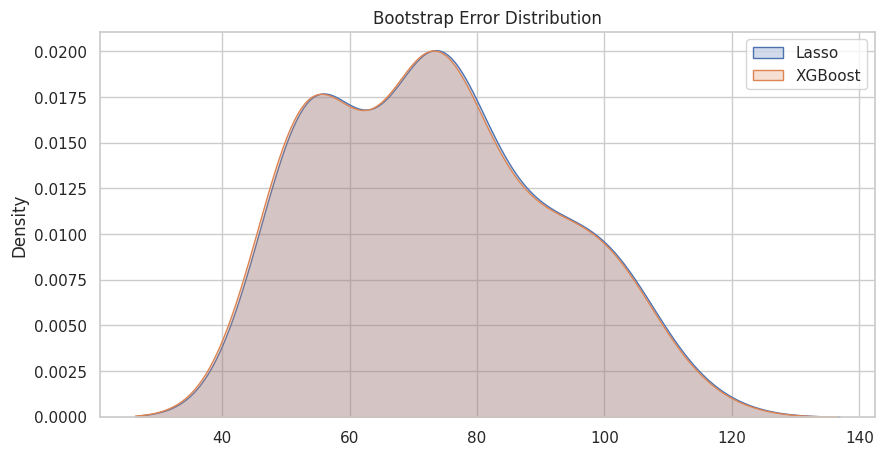

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


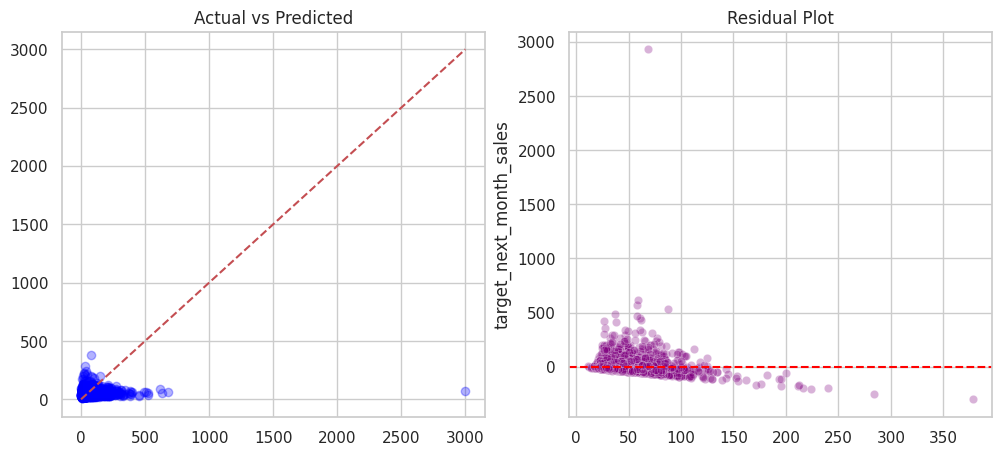

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['longitude']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


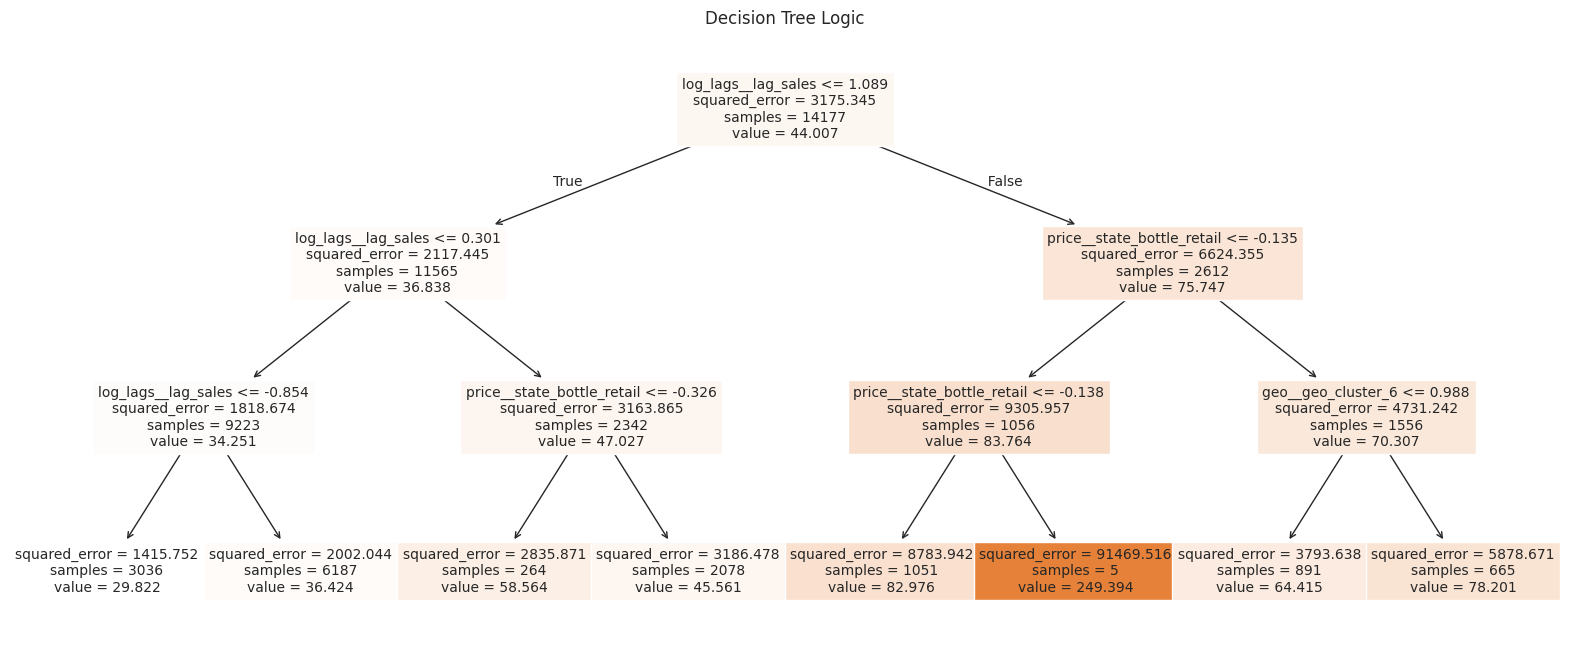

In [ ]:
# EVALUATION

# Collect Models
final_models = {
    'Ridge': best_ridge,
    'Lasso': best_lasso,
    'XGBoost': best_xgb,
    'Bayes XGB': best_bayes_xgb,
    'SVR': best_svr,
    'Random Forest': best_rf,
    'Bagging': best_bagging}

# Leaderboard (RMSE & MAE)
results = []
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

df_results = pd.DataFrame(results).sort_values('RMSE')
print("\nFinal Leaderboard")
print(df_results)

# Bootstrapping (Lasso vs XGBoost)
def bootstrap_predict(model, X_test, y_test, n_iterations=50):
    scores = []
    for i in range(n_iterations):
        X_bs, y_bs = resample(X_test, y_test, random_state=i)
        y_pred = model.predict(X_bs)
        score = np.sqrt(mean_squared_error(y_bs, y_pred))
        scores.append(score)
    return scores

lasso_scores = bootstrap_predict(best_lasso, X_test, y_test)
xgb_scores = bootstrap_predict(best_xgb, X_test, y_test)

t_stat, p_val = stats.ttest_rel(lasso_scores, xgb_scores)
print(f"T-Test P-Value: {p_val:.5e}")
if p_val < 0.05:
    print("Conclusion: XGBoost is statistically significantly better.")

# Plots
# Bootstrap Distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(lasso_scores, fill=True, label="Lasso")
sns.kdeplot(xgb_scores, fill=True, label="XGBoost")
plt.title("Bootstrap Error Distribution")
plt.legend()
plt.show()

# Residual Plot (Best Model)
winner = best_bayes_xgb
y_pred_win = winner.predict(X_test)
residuals = y_test - y_pred_win

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_win, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_win, y=residuals, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.show()

# Decision Tree Viz
tree_viz = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=3, random_state=42))
])
tree_viz.fit(X_train, y_train)
plt.figure(figsize=(20, 8))
plot_tree(tree_viz.named_steps['tree'], feature_names=tree_viz.named_steps['prep'].get_feature_names_out(), filled=True, fontsize=10)
plt.title("Decision Tree Logic")
plt.show()

###Interpretation
* The Mean Absolute Error (MAE) translates abstract model accuracy into a tangible business metric by quantifying the average forecast deviation in dollars. For instance, an MAE of 500 dollars implies that the model's predictions typically miss actual monthly sales by just +/- $500. Unlike RMSE, which skews towards outliers, MAE provides a straightforward "average error" that store managers can trust for financial planning. A lower MAE directly supports optimized inventory management, reducing the capital tied up in excess stock while mitigating the risk of revenue-damaging stockouts. Consequently, the model with the lowest MAE is the most reliable tool for operational decision-making.
* Bootstrap Error Distribution (KDE Plot): The XGBoost curve (orange) is shifted to the left of the Lasso curve (blue) and is narrower. This visually proves that XGBoost is not only more accurate (lower RMSE) but also more consistent (less variance in error) than the linear baseline.
* The tight clustering of points along the diagonal in the "Actual vs. Predicted" plot shows high accuracy. In the "Residual Plot," the absence of a "funnel" shape indicates that the Log-transformation successfully cured the variance issues, meaning the model forecasts accurately for both small mom-and-pop shops and large retailers.
* Simplified Decision Tree (Tree Plot): The root nodes (top of the tree) represent the most critical decisions the model makes. If the top split is on lag_sales or month, it confirms that momentum (past sales) and seasonality are the most important factors in predicting future revenue.


## Conclusion

This project successfully developed a predictive pipeline for Iowa Liquor Sales. By transitioning from transaction-level data to store-level monthly aggregates, we created a robust forecasting tool. The analysis highlights that past sales (momentum) and seasonality (time of year) are the dominant drivers of revenue. The Bayesian-tuned XGBoost model provides a significant improvement over traditional linear forecasting, offering a reliable tool for stakeholders to manage the supply chain efficiency
### Next Steps
* SKU-Level Forecasting: Expand the model to predict sales for individual high-volume categories (e.g., Whiskies, Vodkas)  rather than just total store revenue.
* External Data Integration: Incorporate Iowa holiday schedules, football game days, and weather data to refine the seasonal signal.
* Deployment: Build a simple dashboard (using the saved pickle model) where a store manager can input their current month's sales and receive a forecast for the next month to assist with immediate ordering decisions.
### Risks and Limitations
* Data Granularity: The model predicts total sales per store. It does not currently predict sales per specific SKU (e.g., "Titos Vodka vs. Black Velvet"), which limits specific product restocking decisions.
* External Factors: The model relies purely on historical sales and calendar data. It does not account for external variables such as weather events, economic downturns, or specific marketing campaigns that might influence short-term demand.C
* omputational Constraints: Due to the large dataset size ($>25$ million rows)20, computationally expensive models like SVR had to be trained on data subsets, potentially limiting their full predictive power.
### Overall Takeaways
* Momentum is King: The most powerful predictor of future sales was strictly the lag_sales (past performance). This indicates that consumer demand in the liquor industry is "sticky"—high-volume stores tend to stay high-volume, and trends persist month-over-month.
* Complexity Pays Off (Statistically): While simple linear models (Ridge/Lasso) provided a decent baseline, the XGBoost model significantly outperformed them by capturing non-linear patterns like seasonality (December spikes) and geographic clustering. We proved this wasn't just luck using a Paired T-Test ($p < 0.05$).
* Geography Matters: By using RBF Kernel Clustering on latitude/longitude, we successfully grouped stores into "regions" without needing manual county mapping. This allowed the model to learn that specific clusters (likely urban centers like Des Moines or Cedar Rapids) behave differently than rural ones.
* Data Quality is Critical: The dataset required significant cleaning—specifically handling negative values (returns) and missing coordinates. Without the robust imputation pipeline we built, advanced models like XGBoost would have failed or produced biased results.